In [ ]:
import tensorflow as tf
import tensorflow_federated as tff

# Load the three image datasets
# Assume you have three different datasets: dataset1, dataset2, dataset3

# Define a function to preprocess the data
def preprocess(dataset):
    def element_fn(element):
        return collections.OrderedDict([
            ('x', tf.image.resize(element['image'], (32, 32)) / 255.0),
            ('y', tf.one_hot(element['label'], 10))
        ])
    return dataset.map(element_fn).batch(64)

# Preprocess each dataset
preprocessed_dataset1 = preprocess(dataset1)
preprocessed_dataset2 = preprocess(dataset2)
preprocessed_dataset3 = preprocess(dataset3)

# Define a simple model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Create an instance of the model
model = create_model()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Wrap the model with TensorFlow Federated
def model_fn():
    return tff.learning.from_keras_model(model)

# Create a federated learning process
fed_process = tff.learning.build_federated_averaging_process(model_fn)

# Create a Federated Evaluation
evaluation = tff.learning.build_federated_evaluation(model_fn)

# Federated training loop
for round_num in range(10):
    # Initialize the server state
    state = fed_process.initialize()

    # Train on the three clients
    state, metrics = fed_process.next(state, [preprocessed_dataset1, preprocessed_dataset2, preprocessed_dataset3])

    # Print metrics
    print(f'Round {round_num}: {metrics}')

# Evaluate the federated model
test_metrics = evaluation(state.model, [preprocessed_test_dataset1, preprocessed_test_dataset2, preprocessed_test_dataset3])
print(f'Test Metrics: {test_metrics}')


----------

In [1]:
%%capture
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Aptos Blindness Detection

In [2]:
#Importing the data

train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
submission= pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [3]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

Number of train samples:  3662
Number of test samples:  1928


In [4]:
import pandas_profiling as pp
pp.ProfileReport(train)

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/tmp/ipykernel_26/2476244409.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

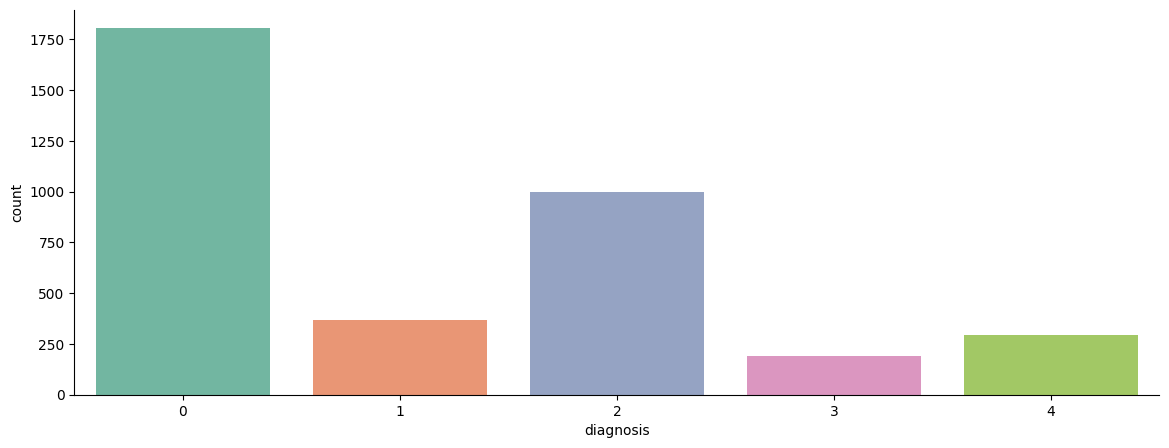

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(14, 5))
ax = sns.countplot(x="diagnosis", data=train, palette="Set2")
sns.despine()
plt.show()

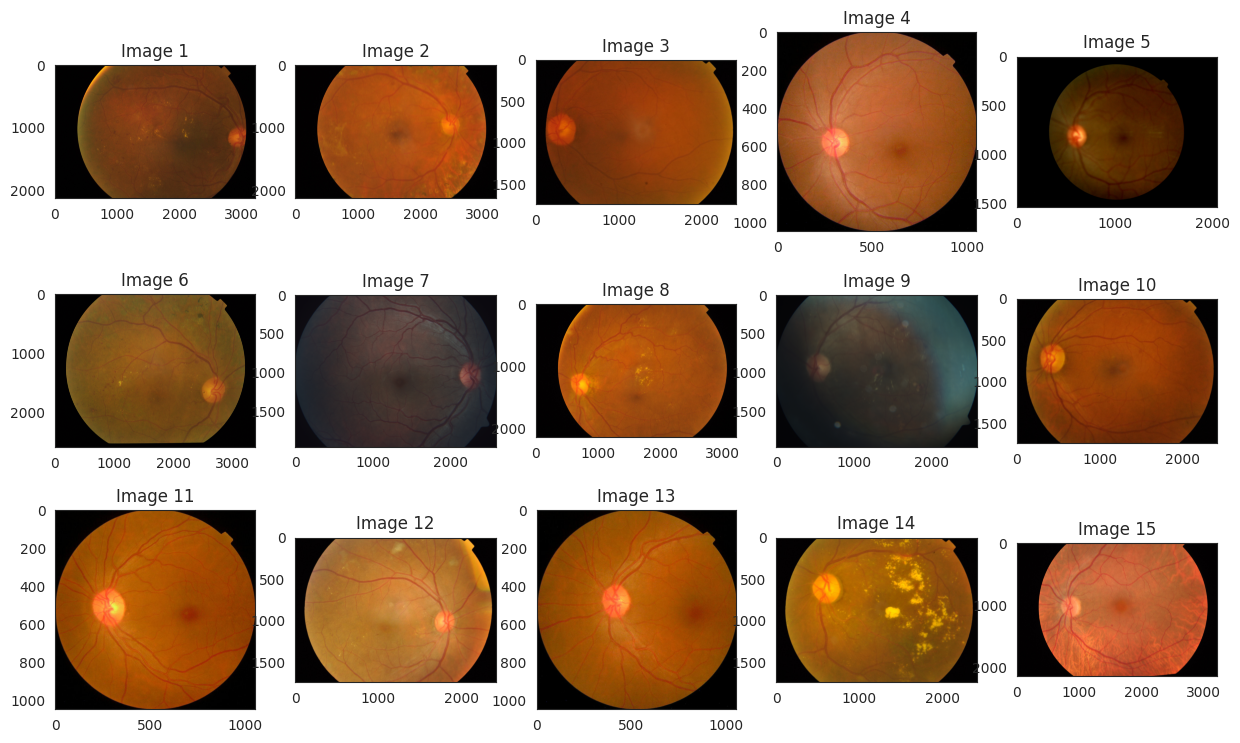

In [6]:
sns.set_style("white")
count = 1
plt.figure(figsize=[15, 15])
for img_name in train['id_code'][:15]:
    img = cv2.imread("../input/aptos2019-blindness-detection/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

In [7]:
N_CLASSES = train['diagnosis'].nunique()
N_CLASSES

5

In [8]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


## Keras Model

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)


train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",
    target_size=(224, 224),
    subset='training')



Found 2930 validated image filenames belonging to 5 classes.


In [10]:
train_datagen

In [11]:
valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",    
    target_size=(224, 224),
    subset='validation')

Found 732 validated image filenames belonging to 5 classes.


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        target_size=(224, 224),
        batch_size=16,
        shuffle=False,
        class_mode=None)

Found 1928 validated image filenames.


## ResNet50

Epoch 1/2
184/184 [==============================] - 526s 3s/step - loss: 1.2435 - accuracy: 0.6294 - val_loss: 1.8974 - val_accuracy: 0.1817
Epoch 2/2
184/184 [==============================] - 318s 2s/step - loss: 1.4920 - accuracy: 0.3017
Train loss: 1.491996169090271 Train accuracy: 0.3017064929008484
121/121 [==============================] - 93s 762ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test loss: 0.0 Test accuracy: 0.0
46/46 [==============================] - 88s 2s/step - loss: 1.4418 - accuracy: 0.3538
Validation loss: 1.4417983293533325 Val accuracy: 0.3538251221179962


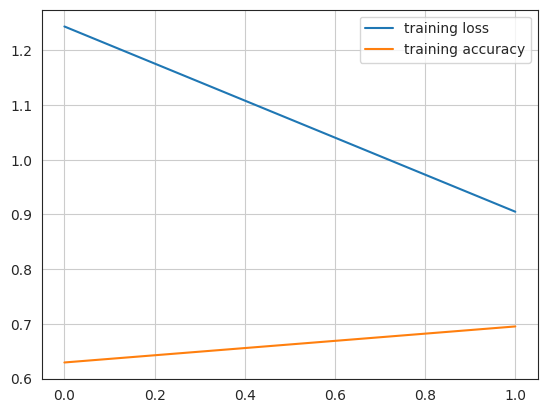

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

model = ResNet50(weights=None, input_shape=(224, 224, 3), classes=5)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)


history = model.fit(train_generator, epochs=2, validation_data=valid_generator)


loss, accuracy = model.evaluate(train_generator)
print("Train loss:", loss, "Train accuracy:", accuracy)

test_loss, test_accuracy = model.evaluate(test_generator)
print("Test loss:", test_loss, "Test accuracy:", test_accuracy)

val_loss, val_accuracy = model.evaluate(valid_generator)
print("Validation loss:", val_loss, "Val accuracy:", val_accuracy)



plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/10
184/184 [==============================] - 412s 2s/step - loss: 1.2022 - accuracy: 0.5532 - val_loss: 1.6660 - val_accuracy: 0.4604
Epoch 2/10
184/184 [==============================] - 404s 2s/step - loss: 0.9357 - accuracy: 0.6642 - val_loss: 1.1025 - val_accuracy: 0.5833
Epoch 3/10
184/184 [==============================] - 404s 2s/step - loss: 0.8879 - accuracy: 0.6898 - val_loss: 0.8619 - val_accuracy: 0.6954
Epoch 4/10
184/184 [==============================] - 405s 2s/step - loss: 0.8566 - accuracy: 0.6983 - val_loss: 0.8215 - val_accuracy: 0.7077
Epoch 5/10
184/184 [==============================] - 407s 2s/step - loss: 0.8586 - accuracy: 0.6939 - val_loss: 0.8053 - val_accuracy: 0.7077
Epoch 6/10
184/184 [==============================] - 403s 2s/step - loss: 0.8223 - accuracy: 0.7055 - val_loss: 0.8505 - val_accuracy: 0.6831
Epoch 7/10
184/184 [==============================] - 404s 2s/step - loss: 0.

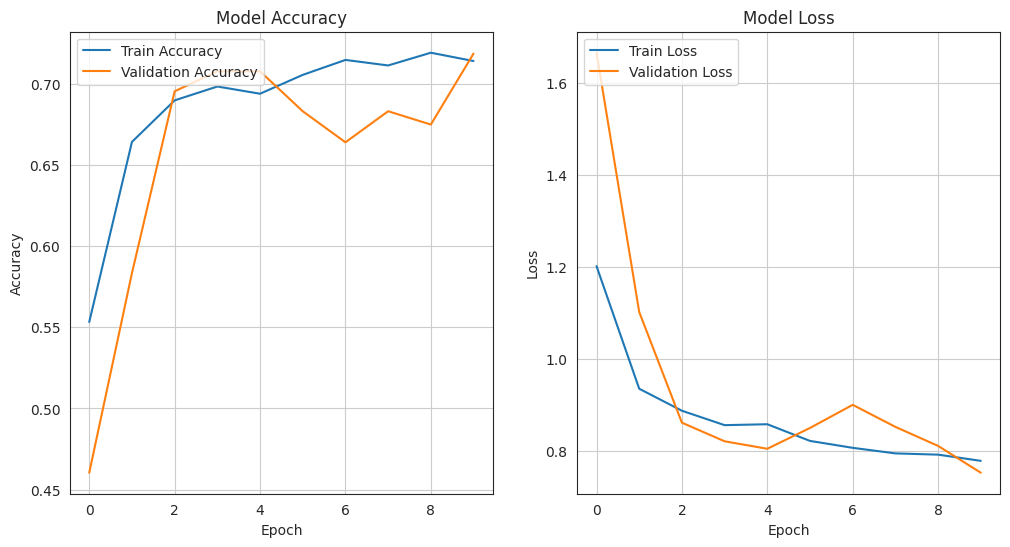

121/121 [==============================] - 74s 604ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Train loss: 0.7301960587501526 Train accuracy: 0.7238907814025879
Validation loss: 0.7670141458511353 Validation accuracy: 0.7158470153808594
Test loss: 0.0 Test accuracy: 0.0


AttributeError: 'DataFrameIterator' object has no attribute 'classes'

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the pre-trained ResNet50 model with ImageNet weights, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new top layer for specific task (5 classes)
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # Assuming 5 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
for layer in base_model.layers[-10:]:  # Unfreeze last 10 layers
    layer.trainable = True

# Recompile the model for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=valid_generator)

# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()

# Evaluate the model on training, validation, and test sets
train_loss, train_accuracy = model.evaluate(train_generator)
val_loss, val_accuracy = model.evaluate(valid_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

# Print accuracy and loss
print("Train loss:", train_loss, "Train accuracy:", train_accuracy)
print("Validation loss:", val_loss, "Validation accuracy:", val_accuracy)
print("Test loss:", test_loss, "Test accuracy:", test_accuracy)

# Generate predictions for test set
y_true = test_generator.classes  # Ground truth labels
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to label indices

# Generate classification report (Precision, Recall, F1-Score)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate specificity for each class
tn_fp_fn_tp = confusion_matrix(y_true, y_pred).ravel()
specificity = []
for i in range(len(conf_matrix)):
    tn = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

# Print specificity for each class
print(f"Specificity per class: {specificity}")

# Final overall performance
print(f"Final Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Final Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")


In [13]:
"""import tensorflow as tf
from tensorflow.keras.applications import ResNet50

model = ResNet50(weights=None, input_shape=(224, 224, 3), classes=5)
"""

In [14]:
"""model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])"""

In [ ]:
"""from tensorflow.keras.utils import plot_model
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)"""

In [ ]:
"""history = model.fit(train_generator, epochs=2, validation_data=valid_generator)"""

Epoch 1/2
184/184 [==============================] - 368s 2s/step - loss: 0.7951 - accuracy: 0.7113 - val_loss: 0.7924 - val_accuracy: 0.7186
Epoch 2/2
184/184 [==============================] - ETA: 0s - loss: 0.7869 - accuracy: 0.7171

In [ ]:
#model.save('imagenet_model.h5')

In [ ]:
"""loss, accuracy = model.evaluate(train_generator)
print("Train loss:", loss, "Train accuracy:", accuracy)"""

In [ ]:
"""test_loss, test_accuracy = model.evaluate(test_generator)
print("Test loss:", test_loss, "Test accuracy:", test_accuracy)"""

In [ ]:
"""val_loss, val_accuracy = model.evaluate(valid_generator)
print("Validation loss:", val_loss, "Val accuracy:", val_accuracy)"""

In [ ]:
"""plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()"""

## VGG16

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in vgg_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(vgg_model)
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))  # Adjust the number of output classes


In [23]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


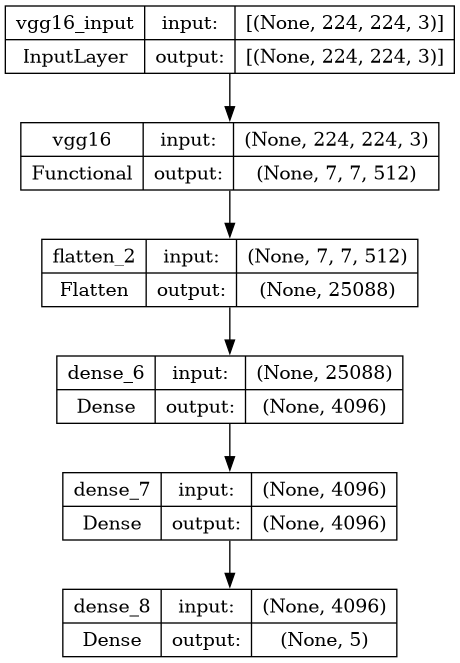

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)

In [25]:
history = model.fit(train_generator, epochs=3, validation_data=valid_generator)

Epoch 1/3
184/184 [==============================] - 460s 2s/step - loss: 115.2632 - accuracy: 0.5700 - val_loss: 12.4778 - val_accuracy: 0.5765
Epoch 2/3
184/184 [==============================] - 363s 2s/step - loss: 4634.2285 - accuracy: 0.5891 - val_loss: 3.0170 - val_accuracy: 0.6776
Epoch 3/3
184/184 [==============================] - 365s 2s/step - loss: 362.4252 - accuracy: 0.6379 - val_loss: 5.2343 - val_accuracy: 0.6079


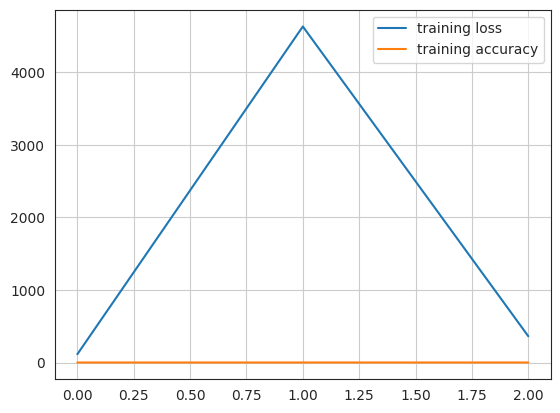

In [26]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

In [27]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=False)

# Train the model with the TensorBoard callback
history = model.fit(train_generator,
                    epochs=3,
                    validation_data=valid_generator,
                    callbacks=[tensorboard_callback])

Epoch 1/3
184/184 [==============================] - 384s 2s/step - loss: 234.6885 - accuracy: 0.6232 - val_loss: 1.6978 - val_accuracy: 0.5615
Epoch 2/3
184/184 [==============================] - 505s 3s/step - loss: 988.5685 - accuracy: 0.6488 - val_loss: 1.2849 - val_accuracy: 0.6776
Epoch 3/3
184/184 [==============================] - 495s 3s/step - loss: 18.1655 - accuracy: 0.6751 - val_loss: 1.6721 - val_accuracy: 0.7063


------------------------------------------
------------------------------------------

# Catarac Dataset

## tensoreflow

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

# Define paths to your dataset folders
train_data_dir = '/kaggle/input/cataractdataset/dataset'
#validation_data_dir = '/path/to/your/dataset/validation'

# Create ImageDataGenerator instances for training and validation data
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True,validation_split=0.2)
#validation_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Create generators for training and validation data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),  # adjust the target size as needed
    batch_size=batch_size,
    class_mode='categorical',  # assuming you have multiple classes
    subset='training'
)



validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


In [ ]:
import matplotlib.pyplot as plt

# Get one image from each class in the training generator
num_classes = len(train_generator.class_indices)
fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

for i in range(num_classes):
    # Get a batch of images for the current class
    class_images, class_labels = next(train_generator, 1)
    
    # Take the first image from the batch
    image = class_images[0]
    
    # Display the image with the class label
    label_index = list(class_labels[0]).index(1)
    class_name = [class_name for class_name, index in train_generator.class_indices.items() if index == label_index][0]
    axes[i].imshow(image)
    axes[i].set_title(f'Class: {class_name}')
    axes[i].axis('off')  # Turn off axis for better visualization

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Get one image from each class in the validation generator
num_classes = len(validation_generator.class_indices)
fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

for i in range(num_classes):
    # Get a batch of images for the current class
    class_images, class_labels = next(validation_generator, 1)
    
    # Take the first image from the batch
    image = class_images[0]
    
    # Display the image with the class label
    label_index = list(class_labels[0]).index(1)
    class_name = [class_name for class_name, index in validation_generator.class_indices.items() if index == label_index][0]
    axes[i].imshow(image)
    axes[i].set_title(f'Class: {class_name}')
    axes[i].axis('off')


### Resnet50

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

model = ResNet50(weights=None, input_shape=(224, 224, 3), classes=4)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)

In [ ]:
history = model.fit(train_generator, epochs=5, validation_data=validation_generator)

In [ ]:
loss, accuracy = model.evaluate(train_generator)
print("Train loss:", loss, "Train accuracy:", accuracy)

In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation loss:", val_loss, "Val accuracy:", val_accuracy)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

### VGG16

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in vgg_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(vgg_model)
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))  # Adjust the number of output classes


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


58889256/58889256 [==============================] - 2s 0us/step
